# SVM pour la discrimination binaire
Les codes informatiques seront implémentés sous R à l’aide des deux packages `e1071` et `kernlab` dédiés essentiellement aux SVM, puis à l’aide du package généraliste `caret`.

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(library(e1071))
suppressWarnings(suppressMessages(library(kernlab)))
suppressWarnings(library(caret))
suppressWarnings(library(doParallel))

Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

Loading required package: foreach

Attaching package: 'foreach'

The following objects are masked from 'package:purrr':

    accumulate, when

Loading required package: iterators
Loading required package: parallel


In [2]:
datasep <- list()
for (data in c("nearsep1", "nearsep2", "nonsep")){
    datasep[[data]] <- read_delim(paste0("../data/",data,".txt"), delim = ";", col_types = "_fdd")
}

## Partie 1 : SVM linéaire sur données presque linéairement séparables
Lancer à l’aide de la fonction `ksvm` et/ou `svm` une SVM linéaire sur les données du fichier `nearsep1.txt`, avec uneconstante de tolérance $C$ égale à 1. Représenter graphiquement le résultat obtenu. Repérer les vecteurs supports, et donner une interprétation de ces vecteurs supports.

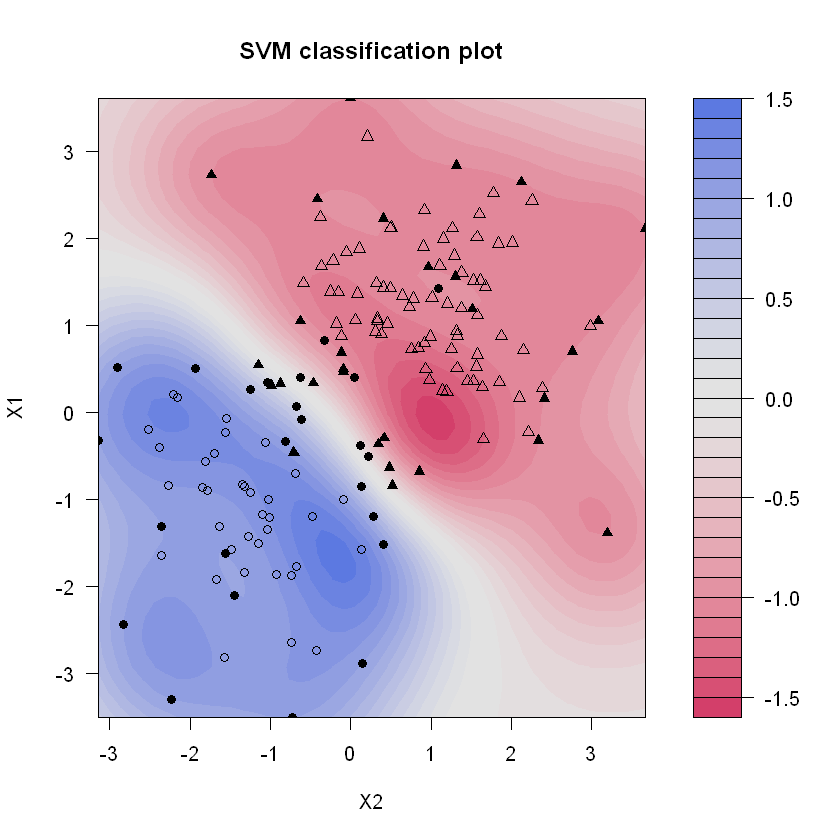

In [3]:
svm_1 <- kernlab::ksvm(
    Y~., data = datasep[['nearsep1']],
    type = "C-svc", kernlabel = "vanilladot",
    C = 1, scaled = F
)

kernlab::plot(svm_1, data = datasep[['nearsep1']])

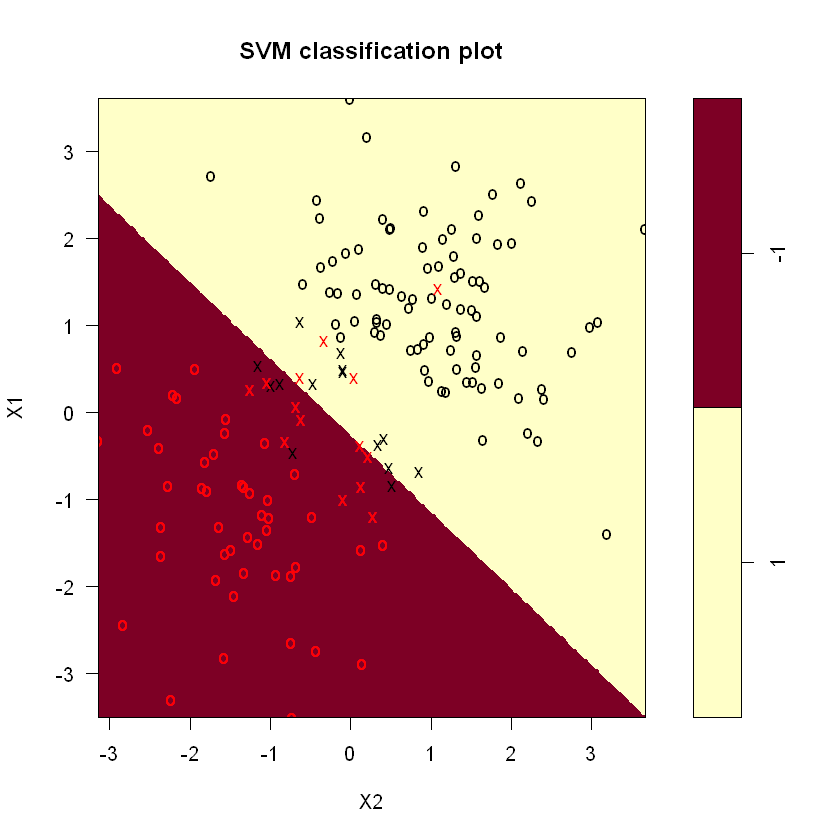

In [4]:
svm_2 <- e1071::svm(
    Y~., data = datasep[['nearsep1']],
    type = 'C-classification', kernel = 'linear',
    cost = 1, scale = F
)

svm_2 %>% plot(data = datasep[['nearsep1']], grid = 300)

Afficher un résumé du modèle de SVM linéaire obtenu à l’aide de `summary( )`.

In [5]:
cat('##### kernlab #####')
summary(svm_1)
cat('##### e1071 #####')
summary(svm_2)

##### kernlab #####

Length  Class   Mode 
     1   ksvm     S4 

##### e1071 #####


Call:
svm(formula = Y ~ ., data = datasep[["nearsep1"]], type = "C-classification", 
    kernel = "linear", cost = 1, scale = F)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1 

Number of Support Vectors:  28

 ( 14 14 )


Number of Classes:  2 

Levels: 
 1 -1




Extraire le vecteur orthogonal $w$ et $b$ pour définir l’hyperplan separateur dont l’équation est donnée par : $$\langle w, (x_1, x_2)\rangle + b = 0$$

In [6]:
Y <- datasep$nearsep1 %>% pull(Y)
X <- datasep$nearsep1[,2:3]
w <- colSums(svm_1@coef[[1]] * X[svm_1@alphaindex[[1]],]); w
paste('b:', svm_1@b)

X1        X2 
-19.19034 -17.90463

[1] "b: 0.161918495912748"

In [7]:
w <-colSums(as.vector(svm_2$coefs) * svm_2$SV); w
paste('b:', svm_2$rho)

X1       X2 
1.204668 1.061238

[1] "b: -0.297622831356401"

Afficher les sorties prédites par la SVM, et les confronter avec les vraies sorties. En déduire son risque apparent.

In [8]:
table(svm_1@fitted, Y)
paste('Train accuracy:', 1-mean(svm_1@fitted!=Y))

    Y
      1 -1
  1  96  6
  -1  4 54

[1] "Train accuracy: 0.9375"

Estimer le risque moyen de la SVM par validation croisée 5-fold

In [9]:
svm_3 <- kernlab::ksvm(
    Y~., data = datasep[['nearsep1']],
    type = "C-svc", kernlabel = "vanilladot",
    C = 1, scaled = F, cross = 5
)
paste('Mean accuracy:', 1-svm_3@error)

[1] "Mean accuracy: 0.9375"

In [10]:
svm_4 <- e1071::svm(
    Y~., data = datasep[['nearsep1']],
    type = 'C-classification', kernel = 'linear',
    cost = 1, scale = F, cross = 5
)
paste('Mean accuracy:', mean(svm_4$accuracies), "%")

[1] "Mean accuracy: 91.875 %"

Déterminer la sortie prédite pour les points de coordonnées (0,0) et (−1,0) à l’aide de la fonction `predict`.

In [11]:
cat('##### kernlab #####')
predict(svm_3, newdata = tibble(X1 = c(0,-1), X2 = c(0,0)))
cat('##### e1071 #####')
predict(svm_4, newdata = tibble(X1 = c(0,-1), X2 = c(0,0)))

##### kernlab #####

[1] 1  -1
Levels: 1 -1

##### e1071 #####

1  2 
 1 -1 
Levels: 1 -1

Séparer les données en un échantillon d’apprentissage et un échantillon de validation de son choix. Lancer la SVM linéaire sur l’échantillon d’apprentissage. Estimer son risque moyen sur l’échantillon de validation.

In [12]:
part <- createDataPartition(Y, p = 2/3)
data_train <- datasep[['nearsep1']][part$Resample1,]
X_test <- X[-part$Resample1,]
y_test <- Y[-part$Resample1]

svm_5 <- kernlab::ksvm(
    Y~., data = data_train,
    type = "C-svc", kernlabel = "vanilladot",
    C = 1, scaled = F, cross = 5
)
paste(
    'Test accuracy:',
    1 - mean(predict(svm_5, newdata = X_test)!=y_test)
)

[1] "Test accuracy: 0.886792452830189"

Ajuster la valeur de $C$ par validation croisée 5-fold et par validation hold out, à l’aide de la fonction `tune.svm` du package `e1071`.

   user  system elapsed 
  62.98    0.02   63.14 


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
  cost
 0.017

- best performance: 0.02818182 


[1] "Test accuracy: 0.886792452830189"

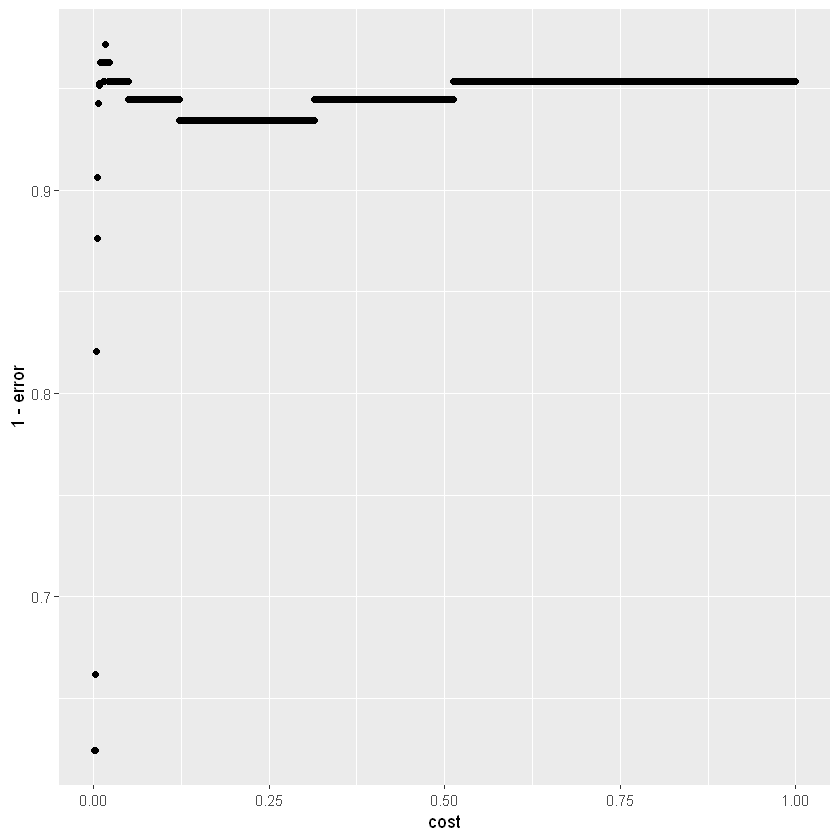

In [13]:
cl <- makePSOCKcluster(6)
time <- proc.time()
registerDoParallel(cl)

svm_6 <- tune.svm(
    Y~., data = data_train,
    kernel = 'linear', type = 'C-classification',
    scale = F, tune.control(sampling = "cross", cross = 5),
    cost = seq(.001, 1, by = .001)
)

on.exit(stopCluster(cl))
proc.time() - time

svm_6

ggplot(svm_6$performances) +
aes(cost, 1-error) + geom_point()

paste(
    'Test accuracy:',
    1 - mean(predict(svm_6$best.model, newdata = X_test)!=y_test)
)

Même chose à l’aide de la fonction `train` du package `caret`.

   user  system elapsed 
   5.03    0.43   16.03 

Support Vector Machine object of class "ksvm" 

SV type: C-svc  (classification) 
 parameter : cost C = 0.021 

Linear (vanilla) kernel function. 

Number of Support Vectors : 60 

Objective Function Value : -0.8986 
Training error : 0.046729 

[1] "Test accuracy: 0.886792452830189"

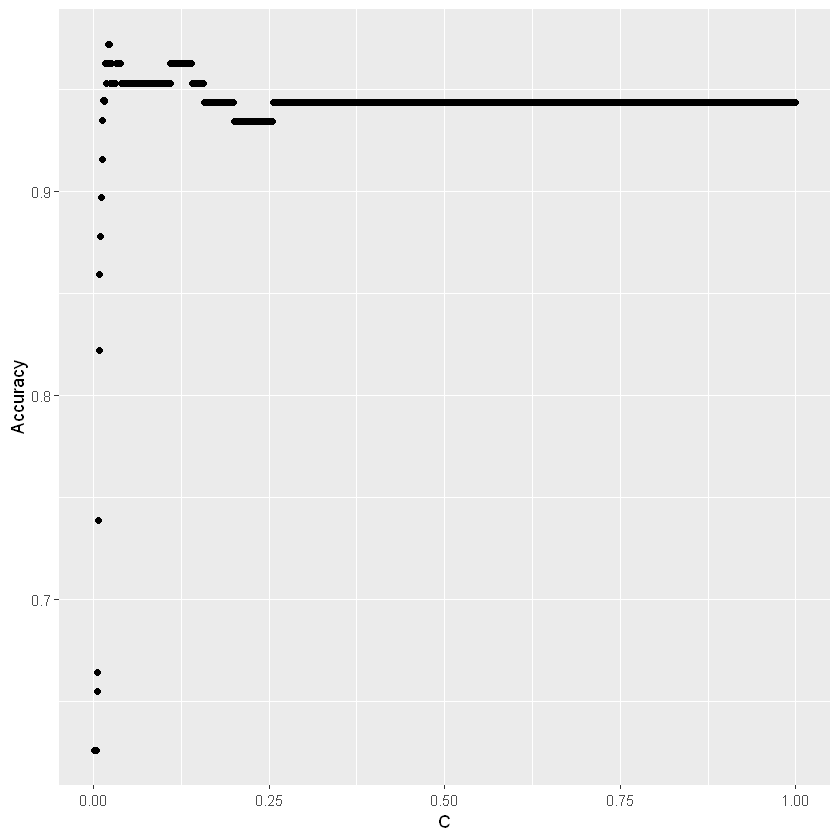

In [14]:
cl <- makePSOCKcluster(6)
time <- proc.time()
registerDoParallel(cl)

svm_7 <- caret::train(
    Y~., data = data_train, method = 'svmLinear',
    trControl = trainControl("cv", number = 5),
    tuneGrid = expand.grid(C = seq(.001, 1, by = .001))
)

on.exit(stopCluster(cl))
proc.time() - time

svm_7$finalModel

ggplot(svm_7$results) +
aes(C, Accuracy) + geom_point()

paste(
    'Test accuracy:',
    1 - mean(predict(svm_7$finalModel, newdata = X_test)!=y_test)
)